1. 더미 데이터 불러오기

In [2]:
import pandas as pd

# 필요한 컬럼만 선택하여 CSV 읽기
selected_columns = [
    "시도명", "시군구명"
]

df = pd.read_csv("./data/소상공인시장진흥공단_상가(상권)정보_경남_202503.csv", 
                 usecols=selected_columns).fillna("")

# 시군구별 데이터 개수 집계
city_counts = df["시군구명"].value_counts().sort_values(ascending=False)
print("경남 시/군별 상가 데이터 개수:")
print(city_counts)

경남 시/군별 상가 데이터 개수:
시군구명
김해시          26565
진주시          19254
양산시          16324
창원시 성산구      13519
거제시          12317
창원시 의창구      11093
창원시 마산합포구     9869
창원시 진해구       8428
창원시 마산회원구     8283
통영시           7385
사천시           6405
밀양시           5737
거창군           3341
남해군           3212
창녕군           3156
함안군           2939
하동군           2856
고성군           2647
함양군           2123
산청군           1995
합천군           1946
의령군           1074
Name: count, dtype: int64


In [3]:
import pandas as pd

# 필요한 컬럼만 선택하여 CSV 읽기 (상위 100줄만)
selected_columns = [
    "상권업종대분류코드", "상권업종대분류명", "상권업종중분류코드", "상권업종중분류명", 
    "상권업종소분류코드", "상권업종소분류명", "시도코드", "시도명", "시군구코드", "시군구명", 
    "행정동코드", "행정동명", "법정동명", "지번주소", "도로명주소", "경도", "위도"
]

df = pd.read_csv("./data/소상공인시장진흥공단_상가(상권)정보_경남_202503.csv", 
                 usecols=selected_columns,
                 #nrows=10000
                 ).fillna("")

# 시군구명이 "남해군"인 데이터만 필터링
cityname = "함안군"
df = df[df["시군구명"] == cityname].reset_index(drop=True)

print(f"{cityname} 데이터 수: {len(df)}개")
print(f"\n{cityname} 내 시군구별 분포:")
print(df["시군구명"].value_counts())

# 텍스트 컬럼 생성 (주소 정보를 결합)
df["text"] = (df["시도명"].str.strip() + " " + 
              df["시군구명"].str.strip() + " " + 
              df["행정동명"].str.strip() + " " + 
              df["상권업종대분류명"].str.strip() + " " + 
              df["상권업종중분류명"].str.strip() + " " + 
              df["상권업종소분류명"].str.strip())

print(f"\n=== {cityname} 상가 데이터 샘플 ===")

print(df.head(2))

함안군 데이터 수: 2939개

함안군 내 시군구별 분포:
시군구명
함안군    2939
Name: count, dtype: int64

=== 함안군 상가 데이터 샘플 ===
  상권업종대분류코드 상권업종대분류명 상권업종중분류코드 상권업종중분류명 상권업종소분류코드 상권업종소분류명  시도코드   시도명  시군구코드  \
0        G2       소매      G204    종합 소매    G20404     슈퍼마켓    48  경상남도  48730   
1        I2       음식      I211       주점    I21104    요리 주점    48  경상남도  48730   

  시군구명     행정동코드 행정동명 법정동명                     지번주소                   도로명주소  \
0  함안군  48730253  칠원읍  칠원읍  경상남도 함안군 칠원읍 운서리 1099-1  경상남도 함안군 칠원읍 운무로 217-9   
1  함안군  48730250  가야읍  가야읍   경상남도 함안군 가야읍 말산리 628-4     경상남도 함안군 가야읍 가야로 67   

           경도         위도                        text  
0  128.538582  35.318233  경상남도 함안군 칠원읍 소매 종합 소매 슈퍼마켓  
1  128.408486  35.278019    경상남도 함안군 가야읍 음식 주점 요리 주점  


2. 전처리(클렌징)

In [4]:
import re

def clean(txt: str) -> str:
    txt = re.sub(r"http\S+|www\S+", " ", txt)            # URL
    txt = re.sub(r"[^\w가-힣\s]", " ", txt)              # 특수문자
    txt = re.sub(r"\s+", " ", txt).strip()               # 중복 공백
    return txt.lower()

df["clean"] = df["text"].apply(clean)

3. SimCSE 임베딩

In [5]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

MODEL_ID = "BM-K/KoSimCSE-roberta"      # unsupervised 버전
embedder = SentenceTransformer(MODEL_ID)

BATCH = 256
emb_list = []
for i in tqdm(range(0, len(df), BATCH)):
    batch = df["clean"].iloc[i : i + BATCH].tolist()
    embs  = embedder.encode(batch, batch_size=len(batch),
                            normalize_embeddings=True)
    emb_list.extend(embs)
import numpy as np
emb = np.vstack(emb_list).astype("float32")              # (N, 768)

No sentence-transformers model found with name BM-K/KoSimCSE-roberta. Creating a new one with mean pooling.
100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


normalize_embeddings=True → 이미 L2 노멀라이즈된 벡터라 Inner Product = 코사인.

4. FAISS 인덱스 생성

In [6]:
import faiss

d = emb.shape[1]                     # 768
index = faiss.IndexFlatIP(d)         # 작은 데이터셋은 Flat IP로 충분
index.add(emb)                       # 전체 아이디어 삽입

5. 유사 아이디어 검색 함수

In [7]:
def find_similar(query: str, top_k: int = 5):
    q_emb = embedder.encode([clean(query)],
                            normalize_embeddings=True).astype("float32")
    D, I = index.search(q_emb, top_k)      # D: 코사인, I: 행 인덱스
    return list(zip(I[0], D[0]))           # [(idx, score), …]

def find_similar_with_details(query: str, top_k: int = 5):
    """검색 결과와 함께 상가 정보도 보여주는 함수"""
    results = find_similar(query, top_k)
    print(f"검색어: '{query}'")
    print(f"상위 {top_k}개 결과:")
    print("-" * 50)
    
    for i, (idx, score) in enumerate(results, 1):
        row = df.iloc[idx]
        print(f"{i}. 유사도: {score:.3f}")
        print(f"   상호명: {row.get('상호명', 'N/A')}")
        print(f"   업종: {row['상권업종대분류명']} > {row['상권업종중분류명']} > {row['상권업종소분류명']}")
        print(f"   위치: {row['시도명']} {row['시군구명']} {row['행정동명']}")
        print(f"   주소: {row['지번주소']}")
        print()

# 실제 상가 데이터에 맞는 검색어로 테스트
print("=== 실제 상가 데이터 검색 테스트 ===")
find_similar_with_details("진주시 꽃집")
print()
find_similar_with_details("김해시 의원")
print()
find_similar_with_details("경상남도 소매")

=== 실제 상가 데이터 검색 테스트 ===
검색어: '진주시 꽃집'
상위 5개 결과:
--------------------------------------------------
1. 유사도: 0.714
   상호명: N/A
   업종: 소매 > 식물 소매 > 꽃집
   위치: 경상남도 함안군 가야읍
   주소: 경상남도 함안군 가야읍 산서리 684-518

2. 유사도: 0.714
   상호명: N/A
   업종: 소매 > 식물 소매 > 꽃집
   위치: 경상남도 함안군 가야읍
   주소: 경상남도 함안군 가야읍 검암리 1002-2

3. 유사도: 0.714
   상호명: N/A
   업종: 소매 > 식물 소매 > 꽃집
   위치: 경상남도 함안군 가야읍
   주소: 경상남도 함안군 가야읍 가야리 893

4. 유사도: 0.714
   상호명: N/A
   업종: 소매 > 식물 소매 > 꽃집
   위치: 경상남도 함안군 가야읍
   주소: 경상남도 함안군 가야읍 가야리 60-1

5. 유사도: 0.714
   상호명: N/A
   업종: 소매 > 식물 소매 > 꽃집
   위치: 경상남도 함안군 가야읍
   주소: 경상남도 함안군 가야읍 말산리 470-9


검색어: '김해시 의원'
상위 5개 결과:
--------------------------------------------------
1. 유사도: 0.602
   상호명: N/A
   업종: 보건의료 > 의원 > 기타 의원
   위치: 경상남도 함안군 가야읍
   주소: 경상남도 함안군 가야읍 말산리 626-10

2. 유사도: 0.555
   상호명: N/A
   업종: 보건의료 > 의원 > 이비인후과 의원
   위치: 경상남도 함안군 가야읍
   주소: 경상남도 함안군 가야읍 말산리 460-1

3. 유사도: 0.547
   상호명: N/A
   업종: 보건의료 > 의원 > 안과 의원
   위치: 경상남도 함안군 가야읍
   주소: 경상남도 함안군 가야읍 말산리 609-3

4. 유사도: 0.546


6. HDBSCAN 클러스터링

In [8]:
import hdbscan, joblib, numpy as np

n = len(df)                                     # 현재 데이터 크기
#min_cluster = max(2, int(0.2 * n))              # 20% 또는 최소 2
#min_samples = min(min_cluster, n - 1)

# 관대한 파라미터
min_cluster = 20    # 20개만 모여도 클러스터
min_samples = 10         # 10개 이웃만 있어도 핵심 포인트

clusterer = hdbscan.HDBSCAN(
        metric="euclidean",
        min_cluster_size=min_cluster,
        min_samples=min_samples,
        prediction_data=True
).fit(emb)

df["cluster"] = clusterer.labels_
print(df["cluster"].value_counts())
joblib.dump(clusterer, "hdbscan.pkl")

/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


cluster
-1     640
 37     98
 49     75
 27     67
 24     67
 39     65
 19     64
 28     62
 9      62
 25     60
 52     60
 48     59
 51     57
 0      57
 5      56
 3      52
 55     52
 4      51
 23     48
 7      48
 31     47
 36     47
 35     47
 42     43
 34     43
 41     42
 8      42
 20     40
 50     40
 40     35
 12     34
 17     34
 54     33
 53     32
 1      32
 30     31
 38     31
 44     31
 15     31
 22     31
 43     28
 29     25
 16     25
 13     25
 6      24
 45     24
 2      24
 21     23
 46     23
 11     23
 26     23
 33     22
 32     21
 47     21
 10     21
 18     21
 14     20
Name: count, dtype: int64


['hdbscan.pkl']

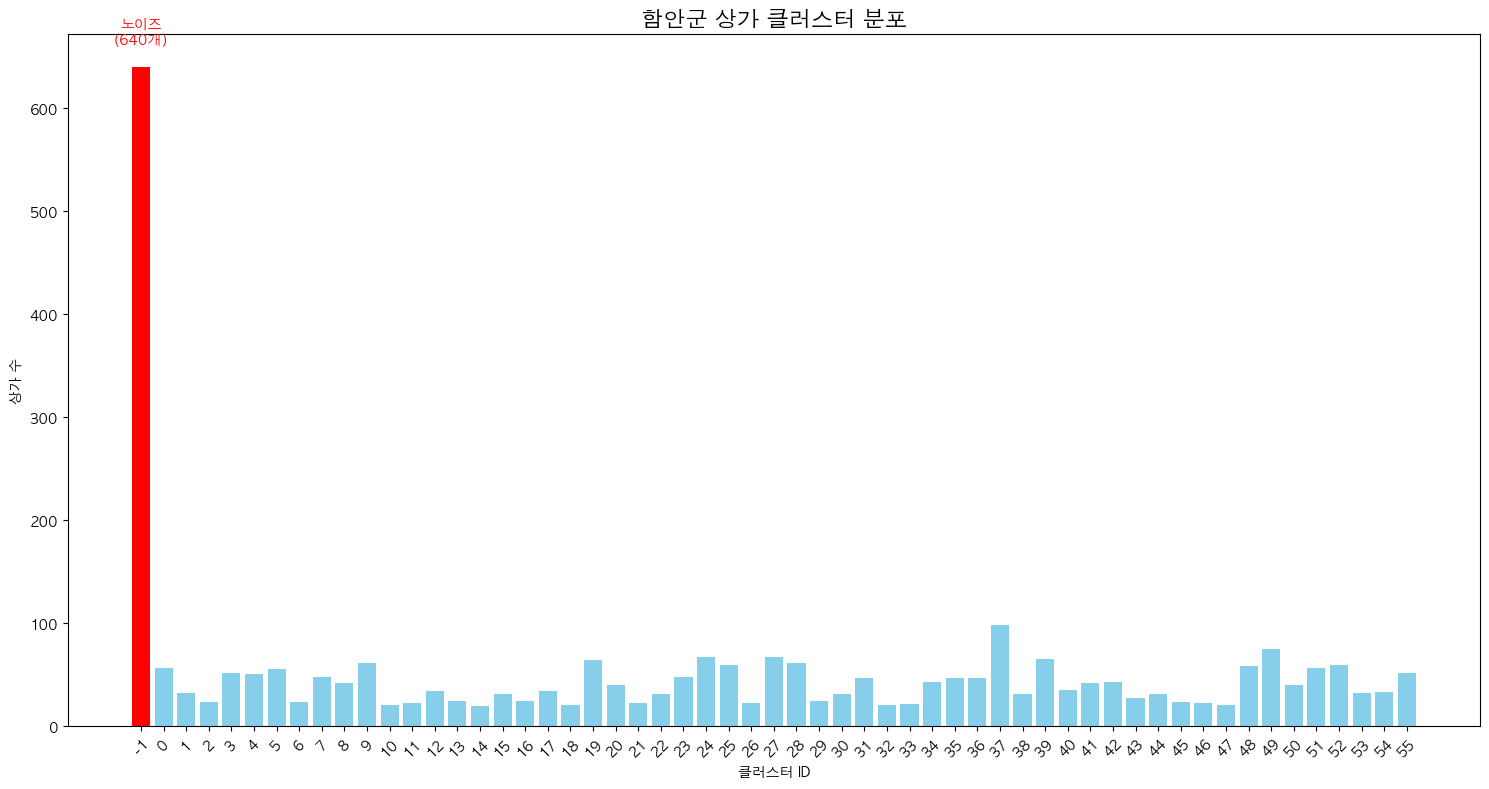

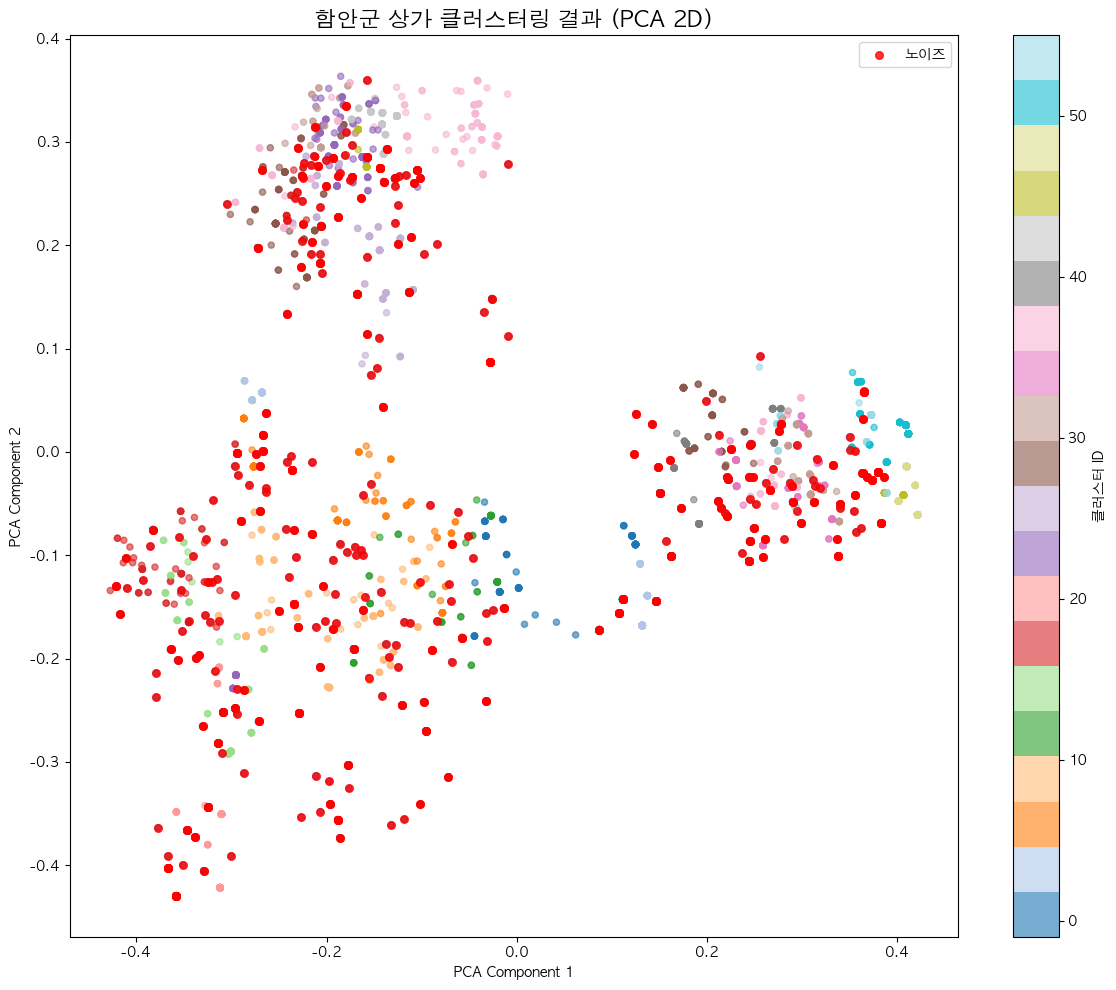

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # macOS용
plt.rcParams['axes.unicode_minus'] = False

# 1. 클러스터 분포 막대 그래프
plt.figure(figsize=(15, 8))
cluster_counts = df['cluster'].value_counts().sort_index()
colors = ['red' if x == -1 else 'skyblue' for x in cluster_counts.index]

plt.bar(range(len(cluster_counts)), cluster_counts.values, color=colors)
plt.title(f'{cityname} 상가 클러스터 분포', fontsize=16, fontweight='bold')
plt.xlabel('클러스터 ID')
plt.ylabel('상가 수')
plt.xticks(range(len(cluster_counts)), cluster_counts.index, rotation=45)

# 노이즈 클러스터(-1) 강조
plt.text(0, cluster_counts.iloc[0] + 20, f'노이즈\n({cluster_counts.iloc[0]}개)', 
         ha='center', va='bottom', fontweight='bold', color='red')

plt.tight_layout()
plt.show()

# 2. PCA로 2D 시각화
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(emb)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=df['cluster'], 
                     cmap='tab20', alpha=0.6, s=20)

# 노이즈 포인트(-1)는 빨간색으로 강조
noise_mask = df['cluster'] == -1
plt.scatter(emb_2d[noise_mask, 0], emb_2d[noise_mask, 1], 
           c='red', alpha=0.8, s=30, label='노이즈')

plt.title(f'{cityname} 상가 클러스터링 결과 (PCA 2D)', fontsize=16, fontweight='bold')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.colorbar(scatter, label='클러스터 ID')
plt.tight_layout()
plt.show()

In [10]:
# 노이즈 상세 분석
cluster_13_data = df[df['cluster'] == -1]

print("=== 노이즈 상세 분석 ===")
print(f"총 상가 수: {len(cluster_13_data)}개")
print(f"전체 대비 비율: {len(cluster_13_data)/len(df)*100:.1f}%")

print("\n1. 업종별 분포:")
print(cluster_13_data['상권업종대분류명'].value_counts())
print("\n   중분류별 분포:")
print(cluster_13_data['상권업종중분류명'].value_counts().head(10))

print("\n2. 지역별 분포:")
print(cluster_13_data['행정동명'].value_counts())

print("\n3. 상세 업종별 분포 (상위 15개):")
print(cluster_13_data['상권업종소분류명'].value_counts().head(15))

print("\n4. 노이즈의 상가 샘플 (처음 10개):")
print("-" * 80)
for idx, row in cluster_13_data.head(10).iterrows():
    print(f"• {row['행정동명']} - {row['상권업종대분류명']} > {row['상권업종중분류명']} > {row['상권업종소분류명']}")
    print(f"  주소: {row['지번주소']}")
    print()

=== 노이즈 상세 분석 ===
총 상가 수: 640개
전체 대비 비율: 21.8%

1. 업종별 분포:
상권업종대분류명
음식         222
소매         141
수리·개인      109
과학·기술       60
시설관리·임대     48
교육          18
보건의료        15
부동산         14
예술·스포츠      12
숙박           1
Name: count, dtype: int64

   중분류별 분포:
상권업종중분류명
한식           79
기타 간이        68
이용·미용        45
종합 소매        35
비알코올         34
자동차 수리·세차    19
본사·경영 컨설팅    19
청소·방제        19
욕탕·신체관리      19
주점           18
Name: count, dtype: int64

2. 지역별 분포:
행정동명
가야읍    207
칠원읍    113
대산면     72
법수면     71
산인면     62
군북면     51
칠서면     27
여항면     22
칠북면      8
함안면      7
Name: count, dtype: int64

3. 상세 업종별 분포 (상위 15개):
상권업종소분류명
카페               34
슈퍼마켓             23
해산물 구이/찜         21
피부 관리실           20
빵/도넛             19
경영 컨설팅업          19
자동차 정비소          18
그 외 기타 간이 음식점    16
부동산 중개/대리업       14
목욕탕/사우나          14
네일숍              13
미용실              12
피자               12
편의점              12
돼지고기 구이/찜        12
Name: count, dtype: int64

4. 노이즈의 상가 샘플 (처음 10개):
-----------

In [11]:
# 클러스터 13 상세 분석
cluster_13_data = df[df['cluster'] == 13]

print("=== 클러스터 13 상세 분석 ===")
print(f"총 상가 수: {len(cluster_13_data)}개")
print(f"전체 대비 비율: {len(cluster_13_data)/len(df)*100:.1f}%")

print("\n1. 업종별 분포:")
print(cluster_13_data['상권업종대분류명'].value_counts())
print("\n   중분류별 분포:")
print(cluster_13_data['상권업종중분류명'].value_counts().head(10))

print("\n2. 지역별 분포:")
print(cluster_13_data['행정동명'].value_counts())

print("\n3. 상세 업종별 분포 (상위 15개):")
print(cluster_13_data['상권업종소분류명'].value_counts().head(15))

print("\n4. 클러스터 13의 상가 샘플 (처음 10개):")
print("-" * 80)
for idx, row in cluster_13_data.head(10).iterrows():
    print(f"• {row['행정동명']} - {row['상권업종대분류명']} > {row['상권업종중분류명']} > {row['상권업종소분류명']}")
    print(f"  주소: {row['지번주소']}")
    print()

=== 클러스터 13 상세 분석 ===
총 상가 수: 25개
전체 대비 비율: 0.9%

1. 업종별 분포:
상권업종대분류명
수리·개인    25
Name: count, dtype: int64

   중분류별 분포:
상권업종중분류명
가전제품 수리       21
기타 가정용품 수리     4
Name: count, dtype: int64

2. 지역별 분포:
행정동명
가야읍    9
군북면    6
대산면    4
칠서면    2
칠북면    2
법수면    1
칠원읍    1
Name: count, dtype: int64

3. 상세 업종별 분포 (상위 15개):
상권업종소분류명
가전제품 수리업              21
그 외 기타 개인/가정용품 수리업     4
Name: count, dtype: int64

4. 클러스터 13의 상가 샘플 (처음 10개):
--------------------------------------------------------------------------------
• 대산면 - 수리·개인 > 가전제품 수리 > 가전제품 수리업
  주소: 경상남도 함안군 대산면 평림리 954-26

• 가야읍 - 수리·개인 > 가전제품 수리 > 가전제품 수리업
  주소: 경상남도 함안군 가야읍 춘곡리 530

• 군북면 - 수리·개인 > 가전제품 수리 > 가전제품 수리업
  주소: 경상남도 함안군 군북면 덕대리 257-25

• 군북면 - 수리·개인 > 가전제품 수리 > 가전제품 수리업
  주소: 경상남도 함안군 군북면 수곡리 275

• 군북면 - 수리·개인 > 가전제품 수리 > 가전제품 수리업
  주소: 경상남도 함안군 군북면 중암리 89-4

• 군북면 - 수리·개인 > 가전제품 수리 > 가전제품 수리업
  주소: 경상남도 함안군 군북면 장지리 745-7

• 법수면 - 수리·개인 > 가전제품 수리 > 가전제품 수리업
  주소: 경상남도 함안군 법수면 윤외리 153-25

• 가야읍 - 수리·개인 > 가전제품 수리 > 가전제품 수

In [12]:
# 노이즈 줄이기 위한 HDBSCAN 파라미터 조정 (지원되는 메트릭만 사용)
import hdbscan, joblib, numpy as np

print("=== 노이즈 줄이기 실험 ===")

# 실험 1: 더 관대한 파라미터 (euclidean)
print("\n1. 더 관대한 파라미터로 재실험")
clusterer_1 = hdbscan.HDBSCAN(
    metric="euclidean",
    min_cluster_size=10,      # 20 → 10으로 줄임
    min_samples=5,            # 10 → 5로 줄임
    prediction_data=True,
    cluster_selection_epsilon=0.5,  # 0.3 → 0.5로 증가
    alpha=1.0
).fit(emb)

labels_1 = clusterer_1.labels_
noise_count_1 = len(labels_1[labels_1 == -1])
print(f"노이즈 수: {noise_count_1}개 ({noise_count_1/len(df)*100:.1f}%)")
print(f"클러스터 수: {len(set(labels_1)) - (1 if -1 in labels_1 else 0)}개")

# 실험 2: 가장 관대한 파라미터
print("\n2. 가장 관대한 파라미터로 재실험")
clusterer_2 = hdbscan.HDBSCAN(
    metric="euclidean",
    min_cluster_size=5,       # 최소 클러스터 크기를 5로
    min_samples=3,            # 최소 샘플 수를 3으로
    prediction_data=True,
    cluster_selection_epsilon=0.6,  # 임계값을 0.6으로
    alpha=1.0
).fit(emb)

labels_2 = clusterer_2.labels_
noise_count_2 = len(labels_2[labels_2 == -1])
print(f"노이즈 수: {noise_count_2}개 ({noise_count_2/len(df)*100:.1f}%)")
print(f"클러스터 수: {len(set(labels_2)) - (1 if -1 in labels_2 else 0)}개")

=== 노이즈 줄이기 실험 ===

1. 더 관대한 파라미터로 재실험


/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


노이즈 수: 63개 (2.1%)
클러스터 수: 30개

2. 가장 관대한 파라미터로 재실험


/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


노이즈 수: 1개 (0.0%)
클러스터 수: 10개


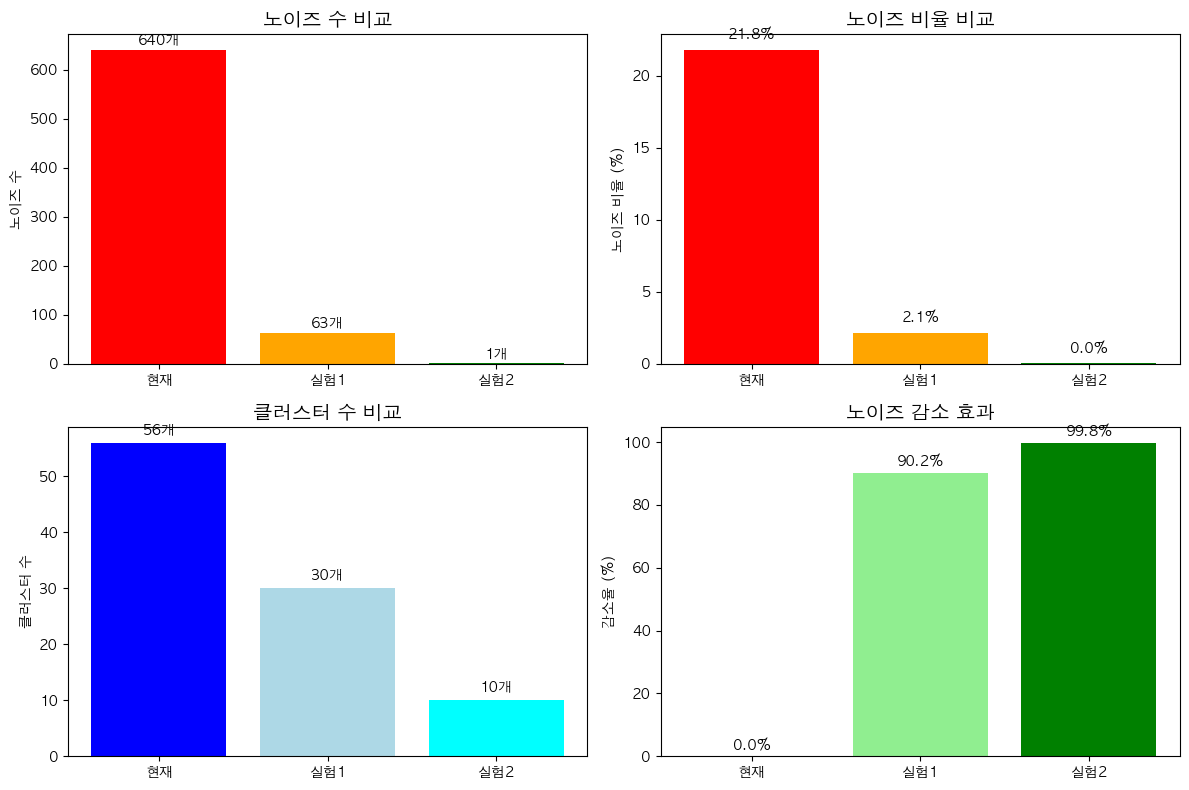

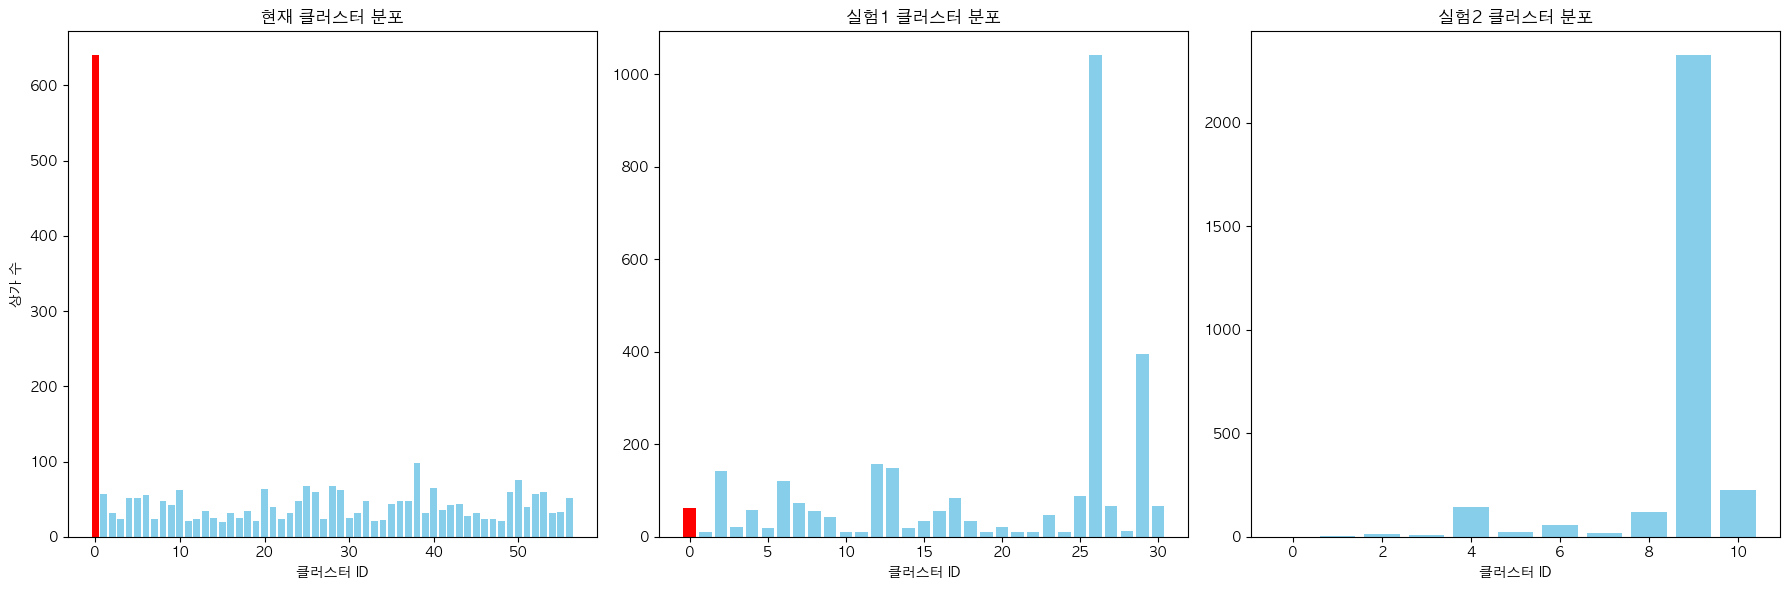

In [13]:
# 노이즈 줄이기 실험 결과 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 실험 결과 데이터 준비
experiment_names = ['현재', '실험1', '실험2']
noise_counts = [
    len(df[df['cluster'] == -1]),  # 현재
    noise_count_1,                 # 실험1
    noise_count_2                  # 실험2
]
cluster_counts = [
    len(set(df['cluster'])) - 1,   # 현재
    len(set(labels_1)) - (1 if -1 in labels_1 else 0),  # 실험1
    len(set(labels_2)) - (1 if -1 in labels_2 else 0)   # 실험2
]

# 1. 노이즈 수 비교 그래프
plt.figure(figsize=(12, 8))

# 서브플롯 1: 노이즈 수 비교
plt.subplot(2, 2, 1)
bars1 = plt.bar(experiment_names, noise_counts, color=['red', 'orange', 'green'])
plt.title('노이즈 수 비교', fontsize=14, fontweight='bold')
plt.ylabel('노이즈 수')
for bar, count in zip(bars1, noise_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{count}개', ha='center', va='bottom', fontweight='bold')

# 서브플롯 2: 노이즈 비율 비교
plt.subplot(2, 2, 2)
noise_ratios = [count/len(df)*100 for count in noise_counts]
bars2 = plt.bar(experiment_names, noise_ratios, color=['red', 'orange', 'green'])
plt.title('노이즈 비율 비교', fontsize=14, fontweight='bold')
plt.ylabel('노이즈 비율 (%)')
for bar, ratio in zip(bars2, noise_ratios):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{ratio:.1f}%', ha='center', va='bottom', fontweight='bold')

# 서브플롯 3: 클러스터 수 비교
plt.subplot(2, 2, 3)
bars3 = plt.bar(experiment_names, cluster_counts, color=['blue', 'lightblue', 'cyan'])
plt.title('클러스터 수 비교', fontsize=14, fontweight='bold')
plt.ylabel('클러스터 수')
for bar, count in zip(bars3, cluster_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{count}개', ha='center', va='bottom', fontweight='bold')

# 서브플롯 4: 개선 효과
plt.subplot(2, 2, 4)
improvement = [(noise_counts[0] - count)/noise_counts[0]*100 for count in noise_counts]
bars4 = plt.bar(experiment_names, improvement, color=['gray', 'lightgreen', 'green'])
plt.title('노이즈 감소 효과', fontsize=14, fontweight='bold')
plt.ylabel('감소율 (%)')
for bar, imp in zip(bars4, improvement):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{imp:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 2. 실험별 클러스터 분포 비교
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 현재 클러스터 분포
current_clusters = df['cluster'].value_counts().sort_index()
axes[0].bar(range(len(current_clusters)), current_clusters.values, 
            color=['red' if x == -1 else 'skyblue' for x in current_clusters.index])
axes[0].set_title('현재 클러스터 분포', fontweight='bold')
axes[0].set_xlabel('클러스터 ID')
axes[0].set_ylabel('상가 수')

# 실험1 클러스터 분포
exp1_clusters = pd.Series(labels_1).value_counts().sort_index()
axes[1].bar(range(len(exp1_clusters)), exp1_clusters.values,
            color=['red' if x == -1 else 'skyblue' for x in exp1_clusters.index])
axes[1].set_title('실험1 클러스터 분포', fontweight='bold')
axes[1].set_xlabel('클러스터 ID')

# 실험2 클러스터 분포
exp2_clusters = pd.Series(labels_2).value_counts().sort_index()
axes[2].bar(range(len(exp2_clusters)), exp2_clusters.values,
            color=['red' if x == -1 else 'skyblue' for x in exp2_clusters.index])
axes[2].set_title('실험2 클러스터 분포', fontweight='bold')
axes[2].set_xlabel('클러스터 ID')

plt.tight_layout()
plt.show()

In [14]:
selected_result = '실험1'  # '현재', '실험1', '실험2' 중 선택

if selected_result == '실험1':
    df['cluster'] = labels_1
    clusterer = clusterer_1
elif selected_result == '실험2':
    df['cluster'] = labels_2
    clusterer = clusterer_2
# '현재'는 이미 반영되어 있음

print(f"\n[{selected_result}] 결과로 데이터프레임이 업데이트되었습니다.")
print(df['cluster'].value_counts().sort_index())


[실험1] 결과로 데이터프레임이 업데이트되었습니다.
cluster
-1       63
 0       11
 1      142
 2       22
 3       58
 4       19
 5      121
 6       72
 7       55
 8       42
 9       10
 10      11
 11     157
 12     149
 13      19
 14      33
 15      56
 16      84
 17      34
 18      11
 19      21
 20      10
 21      10
 22      48
 23      10
 24      88
 25    1041
 26      67
 27      13
 28     395
 29      67
Name: count, dtype: int64


In [15]:
print(f"\n=== {selected_result} 클러스터별 주요 업종/지역 분석 ===")
for cluster_id in sorted(df['cluster'].unique()):
    if cluster_id != -1:  # 노이즈 제외
        cluster_data = df[df['cluster'] == cluster_id]
        print(f"\n클러스터 {cluster_id} ({len(cluster_data)}개):")
        # 주요 업종 대분류
        major_business = cluster_data['상권업종대분류명'].value_counts().head(3)
        print(f"  주요 업종: {dict(major_business)}")
        # 주요 지역
        major_area = cluster_data['행정동명'].value_counts().head(3)
        print(f"  주요 지역: {dict(major_area)}")


=== 실험1 클러스터별 주요 업종/지역 분석 ===

클러스터 0 (11개):
  주요 업종: {'수리·개인': 11}
  주요 지역: {'칠원읍': 4, '군북면': 3, '가야읍': 2}

클러스터 1 (142개):
  주요 업종: {'음식': 142}
  주요 지역: {'가야읍': 52, '칠원읍': 19, '군북면': 13}

클러스터 2 (22개):
  주요 업종: {'보건의료': 15, '과학·기술': 7}
  주요 지역: {'가야읍': 11, '칠원읍': 6, '대산면': 2}

클러스터 3 (58개):
  주요 업종: {'숙박': 58}
  주요 지역: {'가야읍': 16, '산인면': 10, '군북면': 10}

클러스터 4 (19개):
  주요 업종: {'수리·개인': 19}
  주요 지역: {'가야읍': 9, '칠원읍': 5, '대산면': 1}

클러스터 5 (121개):
  주요 업종: {'부동산': 121}
  주요 지역: {'가야읍': 45, '칠원읍': 32, '칠서면': 15}

클러스터 6 (72개):
  주요 업종: {'교육': 72}
  주요 지역: {'가야읍': 32, '칠원읍': 29, '군북면': 4}

클러스터 7 (55개):
  주요 업종: {'예술·스포츠': 55}
  주요 지역: {'가야읍': 17, '칠원읍': 12, '군북면': 5}

클러스터 8 (42개):
  주요 업종: {'예술·스포츠': 42}
  주요 지역: {'가야읍': 16, '칠원읍': 16, '군북면': 3}

클러스터 9 (10개):
  주요 업종: {'과학·기술': 10}
  주요 지역: {'가야읍': 9, '칠원읍': 1}

클러스터 10 (11개):
  주요 업종: {'소매': 11}
  주요 지역: {'가야읍': 7, '칠원읍': 2, '산인면': 1}

클러스터 11 (157개):
  주요 업종: {'수리·개인': 157}
  주요 지역: {'가야읍': 51, '칠원읍': 40, '칠서면': 26}

클러스터 12 (149개):


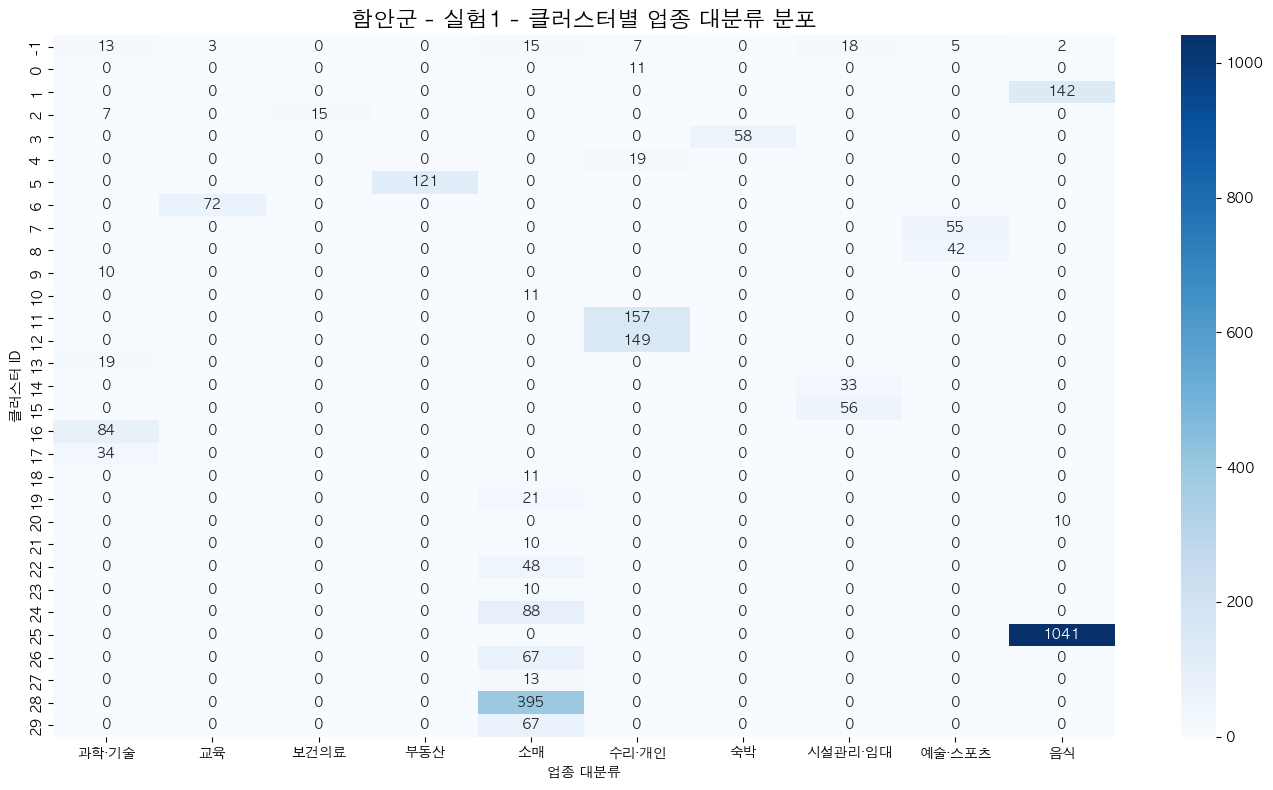

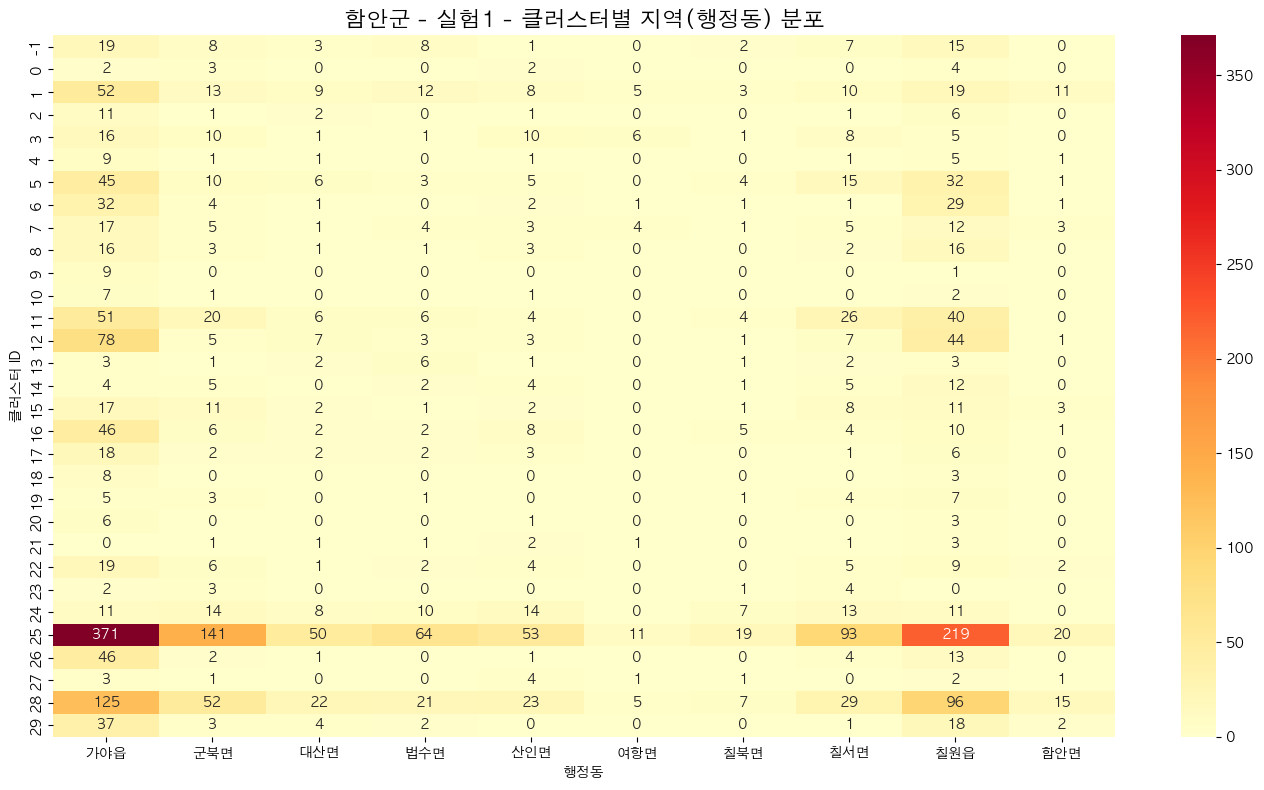

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# 클러스터별 업종 분포 히트맵
plt.figure(figsize=(14, 8))
cluster_business_pivot = pd.crosstab(df['cluster'], df['상권업종대분류명'])
sns.heatmap(cluster_business_pivot, annot=True, fmt='d', cmap='Blues')
plt.title(f'{cityname} - {selected_result} - 클러스터별 업종 대분류 분포', fontsize=16, fontweight='bold')
plt.xlabel('업종 대분류')
plt.ylabel('클러스터 ID')
plt.tight_layout()
plt.show()

# 클러스터별 지역 분포 히트맵
plt.figure(figsize=(14, 8))
cluster_area_pivot = pd.crosstab(df['cluster'], df['행정동명'])
sns.heatmap(cluster_area_pivot, annot=True, fmt='d', cmap='YlOrRd')
plt.title(f'{cityname} - {selected_result} - 클러스터별 지역(행정동) 분포', fontsize=16, fontweight='bold')
plt.xlabel('행정동')
plt.ylabel('클러스터 ID')
plt.tight_layout()
plt.show()

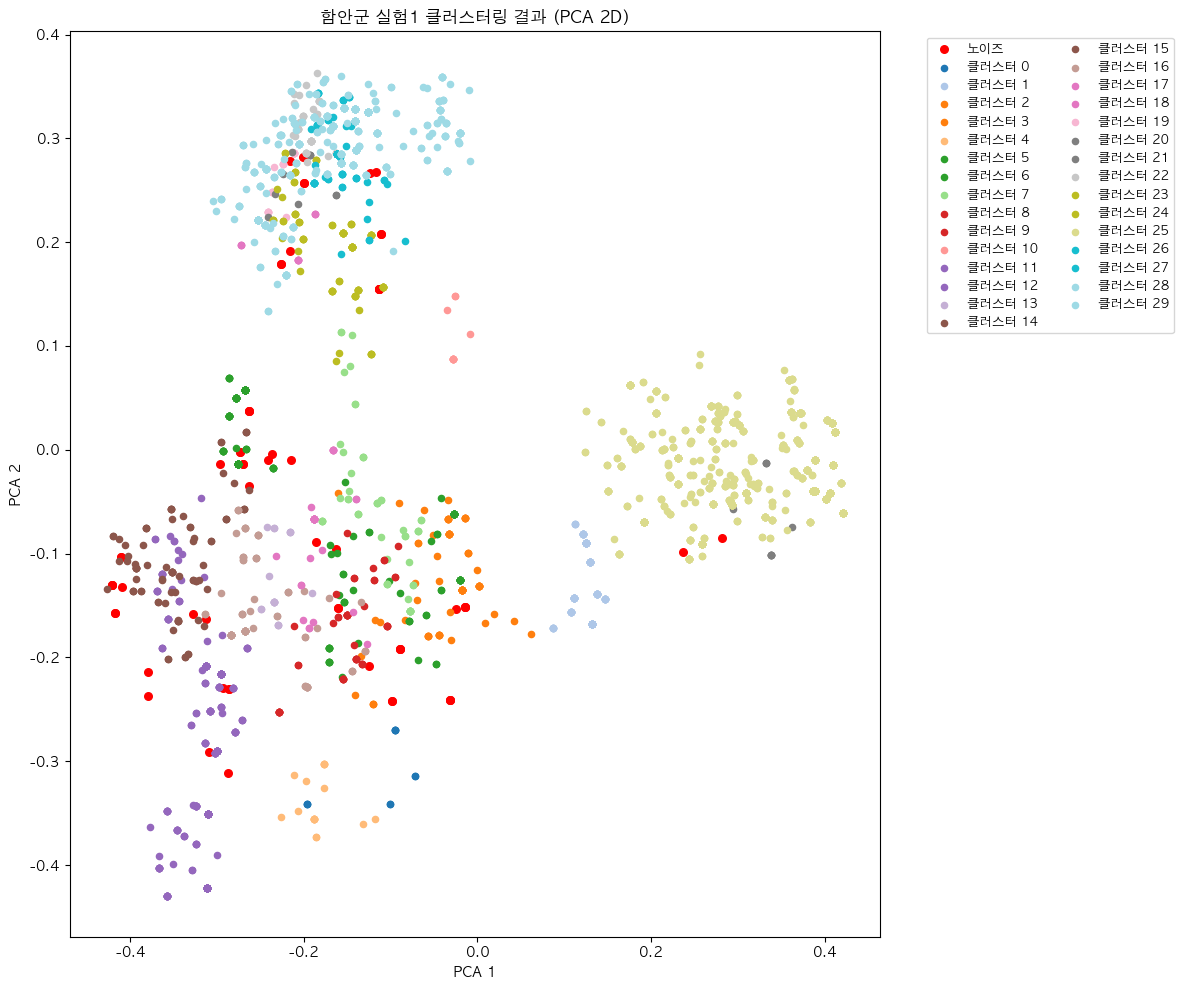

In [21]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(emb)

plt.figure(figsize=(12, 10))
unique_clusters = np.unique(df['cluster'])
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

for i, cluster_id in enumerate(unique_clusters):
    mask = df['cluster'] == cluster_id
    if cluster_id == -1:
        plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], c='red', s=30, label='노이즈')
    else:
        plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], color=colors[i], s=20, label=f'클러스터 {cluster_id}')

plt.title(f'{cityname} 실험1 클러스터링 결과 (PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=2)
plt.tight_layout()
plt.show()

-----

여기부터는 .py 에서 진행

7. 새 글 추가 → 실시간 검색 + 인덱스 갱신

In [12]:
def add_idea(new_row: dict, search_k: int = 5):
    """
    새 아이디어 1건을
      1) 전처리·임베딩
      2) FAISS 검색 → 유사도 top-k 반환
      3) 인덱스·데이터프레임·임베딩 배열 업데이트
    """
    global emb, df, index

    # 1) 전처리 + 임베딩
    cleaned = clean(new_row["title"] + " " + new_row["body"])
    vec     = embedder.encode([cleaned], normalize_embeddings=True).astype("float32")

    # 2) 유사도 검색
    D, I = index.search(vec, search_k)
    similar = [(int(idx), float(score)) for idx, score in zip(I[0], D[0])]

    # 3-A) 인덱스·임베딩 배열 업데이트
    index.add(vec)                          # FAISS에 즉시 반영
    emb = np.vstack([emb, vec])             # ndarray 확장

    # 3-B) 데이터프레임 업데이트
    #     ★ 여기서 오류가 났던 부분 → 중괄호 개수 수정
    df = pd.concat(
        [df, pd.DataFrame([ new_row | {"clean": cleaned} ])],
        ignore_index=True
    )

    return similar

Note: HDBSCAN은 증분 학습이 불가하므로
cron or Airflow로 5분마다 전체 재빌드 (clusterer.fit(emb))를 돌리면 됩니다.

8. 프론트 연동 초간단 API

In [14]:
import sys
!{str(sys.executable)} -m pip install fastapi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached starlette-0.46.2-py3-none-any.whl.metadata (6.2 kB)
  Using cached pydantic-2.11.7-py3-none-any.whl.metadata (67 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.33.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.8 kB)
  Using cached typing_inspection-0.4.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached anyio-4.9.0-py3-none-any.whl.metadata (4.7 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
Using cached pydantic-2.11.7-py3-none-any.whl (444 kB)
Using cached pydantic_core-2.33.2-cp312-cp312-macosx_11_0_arm64.whl (1.8 MB)
Using cached starlette-0.46.2-py3-none-any.whl (72 kB)
Using cached anyio-4.9.0-py3-none-any.whl (100 kB)
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
Using cached sniffio-1.3.1-py3-none-any.whl (10 kB)
Using cached typing_inspection-0.4.1-py3-none-any.whl (14 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [fastapi]m5/8 [anyio]ic]


In [15]:
from fastapi import FastAPI
app = FastAPI()

@app.post("/submit")
def submit(idea: dict):
    sim = add_idea(idea)
    # 코사인 0.7↑ + 같은 cluster 아이템만 추천
    recs = [idx for idx, sc in sim if sc > 0.7 and
            df.loc[idx, "cluster"] == df.iloc[-1]["cluster"]]
    return {"similar_ids": recs}

In [16]:
import sys
!{str(sys.executable)} -m pip install fastapi uvicorn pydantic[dotenv] requests

zsh:1: no matches found: pydantic[dotenv]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
